In [1]:
import os.path as osp
import openslide
from pathlib import Path
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline 
# 이부분 python 에서는 뺴주기

from skimage.filters import threshold_otsu
from openslide.deepzoom import DeepZoomGenerator
import cv2
from keras.utils.np_utils import to_categorical

# network
from keras.models import Sequential
from keras.layers import Lambda, Dropout
from keras.layers.convolutional import Convolution2D, Conv2DTranspose
from keras.layers.pooling import MaxPooling2D
from keras.models import load_model

# Unet
import numpy as np 
import os

import skimage.transform as trans
#import numpy as np
from keras.models import *
from keras.layers import *
from keras.optimizers import *
from keras.callbacks import ModelCheckpoint, LearningRateScheduler
from keras import backend as keras


# train

from sklearn.model_selection import StratifiedShuffleSplit
from datetime import datetime

# evaluate
import matplotlib.gridspec as gridspec
from sklearn.metrics import confusion_matrix
from tqdm import tqdm

import math
from PIL import Image
from xml.etree.ElementTree import ElementTree, Element, SubElement
from io import BytesIO
import skimage.io as io

from tensorflow.python.client import device_lib
#print(device_lib.list_local_devices())
import keras.backend.tensorflow_backend as K
from sklearn import metrics

from keras.preprocessing.image import *

from scipy.ndimage.interpolation import map_coordinates
from scipy.ndimage.filters import gaussian_filter
import matplotlib.pyplot as plt

def elastic_transform(image, alpha, sigma, alpha_affine, random_state=None):
    """Elastic deformation of images as described in [Simard2003]_ (with modifications).
    .. [Simard2003] Simard, Steinkraus and Platt, "Best Practices for
         Convolutional Neural Networks applied to Visual Document Analysis", in
         Proc. of the International Conference on Document Analysis and
         Recognition, 2003.

     Based on https://gist.github.com/erniejunior/601cdf56d2b424757de5
    """
    if random_state is None:
        random_state = np.random.RandomState(None)
    else :
        random_state = np.random.RandomState(42)

    shape = image.shape
    shape_size = shape[:2]
    
    # Random affine
    center_square = np.float32(shape_size) // 2
    square_size = min(shape_size) // 3
    pts1 = np.float32([center_square + square_size, [center_square[0]+square_size, center_square[1]-square_size], center_square - square_size])
    pts2 = pts1 + random_state.uniform(-alpha_affine, alpha_affine, size=pts1.shape).astype(np.float32)
    M = cv2.getAffineTransform(pts1, pts2)
    image = cv2.warpAffine(image, M, shape_size[::-1], borderMode=cv2.BORDER_REFLECT_101)

    dx = gaussian_filter((random_state.rand(*shape) * 2 - 1), sigma) * alpha
    dy = gaussian_filter((random_state.rand(*shape) * 2 - 1), sigma) * alpha
    dz = np.zeros_like(dx)

    x, y, z = np.meshgrid(np.arange(shape[1]), np.arange(shape[0]), np.arange(shape[2]))
    indices = np.reshape(y+dy, (-1, 1)), np.reshape(x+dx, (-1, 1)), np.reshape(z, (-1, 1))

    return map_coordinates(image, indices, order=1, mode='reflect').reshape(shape)

Using TensorFlow backend.


In [2]:
from PIL import ImageEnhance as ie

In [3]:
PATCH_SIZE = 256
IS_TRAIN = True
def find_patches_from_slide(slide_path, truth_path, patch_size=PATCH_SIZE,filter_non_tissue=True,filter_only_all_tumor=True):
    
    slide_contains_tumor = 'pos' in slide_path
    
    ############### read_region을 위한 start, level, size를 구함 #######################
    BOUNDS_OFFSET_PROPS = (openslide.PROPERTY_NAME_BOUNDS_X, openslide.PROPERTY_NAME_BOUNDS_Y)
    BOUNDS_SIZE_PROPS = (openslide.PROPERTY_NAME_BOUNDS_WIDTH, openslide.PROPERTY_NAME_BOUNDS_HEIGHT)

    if slide_contains_tumor:
        with openslide.open_slide(slide_path) as slide:
            start = (int(slide.properties.get('openslide.bounds-x',0)),int(slide.properties.get('openslide.bounds-y',0)))
            level = np.log2(patch_size) 
            level = int(level)
            
            size_scale = tuple(int(slide.properties.get(prop, l0_lim)) / l0_lim
                            for prop, l0_lim in zip(BOUNDS_SIZE_PROPS,
                            slide.dimensions))
            _l_dimensions = tuple(tuple(int(math.ceil(l_lim * scale))
                            for l_lim, scale in zip(l_size, size_scale))
                            for l_size in slide.level_dimensions)
            size = _l_dimensions[level]
            
            slide4 = slide.read_region(start,level,size) 
    else :
        with openslide.open_slide(slide_path) as slide:
            start = (0,0)
            level = np.log2(patch_size) 
            level = int(level)
            
            size_scale = (1,1)
            _l_dimensions = tuple(tuple(int(math.ceil(l_lim * scale))
                            for l_lim, scale in zip(l_size, size_scale))
                            for l_size in slide.level_dimensions)
            size = _l_dimensions[level]
            
            slide4 = slide.read_region(start,level,size) 
    ####################################################################################
    
    
    # is_tissue 부분 
    slide4_grey = np.array(slide4.convert('L'))
    binary = slide4_grey > 0  # black이면 0임
    
    # 검은색 제외하고 흰색영역(배경이라고 여겨지는)에 대해서도 작업해주어야함.
    slide4_not_black = slide4_grey[slide4_grey>0]
    thresh = threshold_otsu(slide4_not_black)
    
    I, J = slide4_grey.shape
    for i in range(I):
        for j in range(J):
            if slide4_grey[i,j] > thresh :
                binary[i,j] = False
    patches = pd.DataFrame(pd.DataFrame(binary).stack())
    patches['is_tissue'] = patches[0]
    patches.drop(0, axis=1,inplace =True)
    patches.loc[:,'slide_path'] = slide_path
    
#     # Test 이면 
#     if IS_TEST:
#         return patches

    # is_tumor 부분
    if slide_contains_tumor:
        with openslide.open_slide(truth_path) as truth:
            thumbnail_truth = truth.get_thumbnail(size) 
        
        patches_y = pd.DataFrame(pd.DataFrame(np.array(thumbnail_truth.convert("L"))).stack())
        patches_y['is_tumor'] = patches_y[0] > 0
        
        # mask된 영역이 애매할 수도 있으므로
        patches_y['is_all_tumor'] = patches_y[0] == 255
        patches_y.drop(0, axis=1, inplace=True)
        samples = pd.concat([patches, patches_y], axis=1) #len(samples)
    else:
        samples = patches
        #dfmi.loc[:,('one','second')] = value
        samples.loc[:,'is_tumor'] = False
        samples.loc[:,'is_all_tumor'] = False
    
    if filter_non_tissue:
        samples = samples[samples.is_tissue == True] # remove patches with no tissue #samples = samples[samples.is_tissue == True]
    
    if filter_only_all_tumor :
        samples['tile_loc'] = list(samples.index)
        all_tissue_samples1 = samples[samples.is_tumor==False]
        all_tissue_samples1 = all_tissue_samples1.append(samples[samples.is_all_tumor==True])
        
        all_tissue_samples1.reset_index(inplace=True, drop=True)
    else :
        return samples
    
    return all_tissue_samples1
NUM_CLASSES = 2 # not_tumor, tumor

file_handles=[]
def gen_imgs(all_image_path, all_mask_path, samples, batch_size, patch_size = PATCH_SIZE, shuffle=True):
   
    num_samples = len(samples)
    # 특정 몇개의 slide만 open 해서 쓰기
    # 4개씩 묶었으니까 
  
    slide_path0 = all_image_path[0]
    slide_path1 = all_image_path[1]
    slide_path2 = all_image_path[2]
    slide_path3 = all_image_path[3]
    
    
    # slide 0~3 까지 미리 열어두기
    slide0 = openslide.open_slide(slide_path0)
    slide1 = openslide.open_slide(slide_path1)
    slide2 = openslide.open_slide(slide_path2)
    slide3 = openslide.open_slide(slide_path3)
    file_handles.append(slide0)
    file_handles.append(slide1)
    file_handles.append(slide2)
    file_handles.append(slide3)
    
    # with openslide.open_slide(slide_path) as slide
    tiles0 = DeepZoomGenerator(slide0,tile_size=patch_size, overlap=0, limit_bounds=False) 
    tiles1 = DeepZoomGenerator(slide1,tile_size=patch_size, overlap=0, limit_bounds=False)
    tiles2 = DeepZoomGenerator(slide2,tile_size=patch_size, overlap=0, limit_bounds=False)
    tiles3 = DeepZoomGenerator(slide3,tile_size=patch_size, overlap=0, limit_bounds=False)
    
    
    if 'pos' in slide_path0:
        start_x0 = int(slide0.properties.get('openslide.bounds-x',0))
        start_y0 = int(slide0.properties.get('openslide.bounds-y',0))
        start_x0 = start_x0 / patch_size
        start_y0 = start_y0 / patch_size
        
        truth0 = openslide.open_slide(all_mask_path[0])
        truth_tiles0 = DeepZoomGenerator(truth0, tile_size=16, overlap=0, limit_bounds=False) 
        
    else : 
        start_x0 = 0
        start_y0 = 0
    
    if 'pos' in slide_path1:
        start_x1 = int(slide1.properties.get('openslide.bounds-x',0))
        start_y1 = int(slide1.properties.get('openslide.bounds-y',0))
        start_x1 = start_x1 / patch_size
        start_y1 = start_y1 / patch_size
        
        truth1 = openslide.open_slide(all_mask_path[1])
        truth_tiles1 = DeepZoomGenerator(truth1, tile_size=16, overlap=0, limit_bounds=False) 
        
    else : 
        start_x1 = 0
        start_y1 = 0
    
    if 'pos' in slide_path2:
        start_x2 = int(slide2.properties.get('openslide.bounds-x',0))
        start_y2 = int(slide2.properties.get('openslide.bounds-y',0))
        start_x2 = start_x2 / patch_size
        start_y2 = start_y2 / patch_size
        
        truth2 = openslide.open_slide(all_mask_path[2])
        truth_tiles2 = DeepZoomGenerator(truth2, tile_size=16, overlap=0, limit_bounds=False) 
        
    else : 
        start_x2 = 0
        start_y2 = 0
        
    if 'pos' in slide_path3:
        start_x3 = int(slide3.properties.get('openslide.bounds-x',0))
        start_y3 = int(slide3.properties.get('openslide.bounds-y',0))
        start_x3 = start_x3 / patch_size
        start_y3 = start_y3 / patch_size
        
        truth3 = openslide.open_slide(all_mask_path[3])
        truth_tiles3 = DeepZoomGenerator(truth3, tile_size=16, overlap=0, limit_bounds=False) 
        
    else : 
        start_x3 = 0
        start_y3 = 0
    

    
    for epo in range(10): # Loop forever so the generator never terminates
        if shuffle:
            samples = samples.sample(frac=1) # shuffle samples

        for offset in range(0, num_samples, batch_size):
            batch_samples = samples.iloc[offset:offset+batch_size]
            aug_size = len(batch_samples)
            images = []
            masks = []
            for _, batch_sample in batch_samples.iterrows(): # 배치마다 deep zoom 하네 약간 비효율적
                
                # 여기서 하나씩 4개 체크해서 해당되는 부분으로 가야지. for 4번 돌리면서 가야한다.
                mask_size_up = np.zeros((patch_size,patch_size))
                a,b=mask_size_up.shape
                
                if batch_sample.slide_path == slide_path0:
                    x, y = batch_sample.tile_loc[::-1]
                    x += start_x0
                    y += start_y0
                    img = tiles0.get_tile(tiles0.level_count-1, (x,y))
                    if 'pos' in slide_path0:
                        mask = truth_tiles0.get_tile(truth_tiles0.level_count-1, batch_sample.tile_loc[::-1])
                        mask = (cv2.cvtColor(np.array(mask), cv2.COLOR_RGB2GRAY) > 0).astype(int)
                            # mask_size_up , 16 to 256
                        for i in range(a):
                            for j in range(b) :
                                k = i//16
                                l = j//16
                                mask_size_up[i,j] = mask[k,l]
                    
                elif batch_sample.slide_path == slide_path1:
                    x, y = batch_sample.tile_loc[::-1]
                    x += start_x1
                    y += start_y1
                    img = tiles1.get_tile(tiles1.level_count-1, (x,y))
                    if 'pos' in slide_path1:
                        mask = truth_tiles1.get_tile(truth_tiles1.level_count-1, batch_sample.tile_loc[::-1])
                        mask = (cv2.cvtColor(np.array(mask), cv2.COLOR_RGB2GRAY) > 0).astype(int)
                            # mask_size_up , 16 to 256
                        for i in range(a):
                            for j in range(b) :
                                k = i//16
                                l = j//16
                                mask_size_up[i,j] = mask[k,l]
                
                elif batch_sample.slide_path == slide_path2:
                    x, y = batch_sample.tile_loc[::-1]
                    x += start_x2
                    y += start_y2
                    img = tiles2.get_tile(tiles2.level_count-1, (x,y))
                    if 'pos' in slide_path2:
                        mask = truth_tiles2.get_tile(truth_tiles2.level_count-1, batch_sample.tile_loc[::-1])
                        mask = (cv2.cvtColor(np.array(mask), cv2.COLOR_RGB2GRAY) > 0).astype(int)
                            # mask_size_up , 16 to 256
                        for i in range(a):
                            for j in range(b) :
                                k = i//16
                                l = j//16
                                mask_size_up[i,j] = mask[k,l]
                
                else:
                    x, y = batch_sample.tile_loc[::-1]
                    x += start_x3
                    y += start_y3
                    img = tiles3.get_tile(tiles3.level_count-1, (x,y))
                    if 'pos' in slide_path3:
                        mask = truth_tiles3.get_tile(truth_tiles3.level_count-1, batch_sample.tile_loc[::-1])
                        mask = (cv2.cvtColor(np.array(mask), cv2.COLOR_RGB2GRAY) > 0).astype(int)
                            # mask_size_up , 16 to 256
                        for i in range(a):
                            for j in range(b) :
                                k = i//16
                                l = j//16
                                mask_size_up[i,j] = mask[k,l]
                
                    

                images.append(np.array(img))
                masks.append(mask_size_up)

            X_train = np.array(images)
            y_train = np.array(masks)
            #print('x_train_shape :', X_train.shape)
            
            y_train = to_categorical(y_train, num_classes=2).reshape(y_train.shape[0], patch_size, patch_size, 2) 
            #print('y_train_shape : ',y_train.shape)
            
            #X_train, y_train = datagen().flow(X_train,y = y_train,batch_size = batch_size)
            X_train, y_train = next(ImageDataGenerator(
                rotation_range = 45,
                horizontal_flip=True,
                vertical_flip=True,
                brightness_range =(0.5,1.)).flow(X_train,y=y_train,batch_size=batch_size))
            
            # more data augmentation
#             for iii in range(aug_size):
#                 test_img = Image.fromarray(X_train[iii].astype('uint8'))
#                 #brightness_param = np.random.uniform(0.25,1)
#                 contrast_param = np.random.uniform(0.75,1.0)
#                 color_param = np.random.uniform(0.5,1.0)
#                 a = ie.Contrast(test_img).enhance(contrast_param)
#                 #a = ie.Brightness(a).enhance(brightness_param)
#                 a = ie.Color(test_img).enhance(color_param)
#                 X_train[iii] = np.array(a)
            #print(X_train.shape)
            #print(y_train.shape)
            # elastic_transform(example_X[i],example_X[i].shape[1]*2,example_X[i].shape[1]*0.08,example_X[i].shape[1]*0.08)
#             for iii in range(aug_size):
#                 X_train[iii] = elastic_transform(example_X[iii],example_X[iii].shape[1]*2,example_X[iii].shape[1]*0.08,example_X[iii].shape[1]*0.08)
            yield X_train, y_train
            
def predict_batch_from_model(patches, model):
    """Predict which pixels are tumor.
    
    input: patch: `batch_size`x256x256x3, rgb image
    input: model: keras model
    output: prediction: 256x256x1, per-pixel tumor probability
    """
    predictions = model.predict(patches)
    predictions = predictions[:, :, :, 1]
    return predictions
def predict_from_model(patch, model):
    """Predict which pixels are tumor.
    
    input: patch: 256x256x3, rgb image
    input: model: keras model
    output: prediction: 256x256x1, per-pixel tumor probability
    """
    
    prediction = model.predict(patch.reshape(1, 256, 256, 3))
    prediction = prediction[:, :, :, 1].reshape(256, 256)
    return prediction

def predict_from_model_n(patch, model):
    """Predict which pixels are tumor.
    
    input: patch: 256x256x3, rgb image
    input: model: keras model
    output: prediction: 256x256x1, per-pixel tumor probability
    """
    
    prediction = model.predict(patch.reshape(1, 256, 256, 3))
    prediction = prediction[:, :, :, 0].reshape(256, 256)
    return prediction

def simple_model(pretrained_weights = None):
    model = Sequential()
    model.add(Lambda(lambda x: x / 255.0 - 0.5, input_shape=(256, 256, 3)))
    model.add(Convolution2D(100, (3, 3), strides=(2, 2), activation='elu', padding='same'))
    model.add(MaxPooling2D())
    model.add(Convolution2D(200, (3, 3), strides=(2, 2), activation='elu', padding='same'))
    model.add(MaxPooling2D())
    model.add(Convolution2D(300, (3, 3), activation='elu', padding='same'))
    model.add(Convolution2D(300, (3, 3), activation='elu',  padding='same'))
    model.add(Dropout(0.2))
    model.add(Convolution2D(2, (1, 1))) # this is called upscore layer for some reason?
    model.add(Conv2DTranspose(2, (31, 31), strides=(16, 16), activation='softmax', padding='same'))

    model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
    
    if(pretrained_weights):
        model.load_weights(pretrained_weights)
        
    return model

In [27]:
SSS = all_image_path[0]
MMM = all_mask_path[0]
SSS[-13:-5]

'Slide003'

In [ ]:
def save_imgs(samples,patch_size = PATCH_SIZE, shuffle = True):
    
    num_samples = len(samples)
    
    for id_n in range(num_samples):
        batch_samples = samples.iloc[id_n:id_n+1]
        slide_path = SSS ###########################################################################
        slide_contains_tumor = 'pos' in slide_path
        mask_size_up = np.zeros((patch_size,patch_size))
        with openslide.open_slide(slide_path) as slide:
            tiles = DeepZoomGenerator(silde,tile_size = patch_size, overlap=0, limit_bounds = False)
            if slide_contains_tumor :
                start_x = int(slide.properties.get('openslide.bound-x',0))
                start_y = int(slide.properties.get('openslide.bound-y',0))
                start_x = start_x / patch_size
                start_y = start_y / patch_size
                
                x,y = batch_sample.tile_loc[::-1]
                x += start_x
                y += start_y
                
                img = tiles.get_tile(tiles.level_count-1,(x,y))
                
                truth_slide_path = '/data/train/mask/positive/' + slide_path[27:35] + '.png'
                truth_slide_path = MMM ###############################################################
                with openslide.open_slide(truth_slide_path) as truth:
                    truth_tiles = DeepZoomGenerator(truth,tile_size=16, overlap = 0, limit_bounds = False)
                    mask = truth_tiles.get_tile(truth_tiles.level_count-1,batch_sample.tile_loc[::-1])
                    # mask는 위에까지만 적용해야할듯.
#                     mask = (cv2.cvtColor(np.array(mask), cv2.COLOR_RGB2GRAY) > 0).astype(int)
#                     # mask_size_up , 16 to 256
#                     k, l = mask.shape
#                     for i in range(k):
#                         for j in range(l):
#                             for o in range(16):
#                                 for p in range(16):
#                                     mask_size_up[i*16+o,j*16+p] = mask[i][j]

            else:
                x = 0
                y = 0

                img = tiles.get_tile(tiles.level_count-1,(x,y))
        if img.size != (patch_size,patch_size):
            print('this tisuue shape is not ',(patch_size,patch_size))
            img = Image.new('RGB', (patch_size,patch_size))
            mask = Image.new('RGB', (patch_size,patch_size))
        
        img.save()
        mask.save
                
                
    while 1:
        if shuffle:
            samples = samples.sample(frac=1)
        for offset in range(0, num_samples, batch_size):
            batch_samples = samples.iloc[offset:offset+batch_size]
            images = []
            masks = []
            for _, batch_sample in batch_samples.iterrows():
                slide_path = batch_sample.slide_path
                slide_path = SSS # 나중에 이 부분은 빼주고
                #print(slide_path)
                slide_contains_tumor = 'pos' in slide_path
                mask_size_up = np.zeros((patch_size,patch_size))
                a,b=mask_size_up.shape

                with openslide.open_slide(slide_path) as slide:
                    tiles = DeepZoomGenerator(slide, tile_size=patch_size,overlap=0,limit_bounds=False)
                    if slide_contains_tumor:
                        start_x = int(slide.properties.get('openslide.bounds-x',0))
                        start_y = int(slide.properties.get('openslide.bounds-y',0))
                        start_x = start_x / patch_size
                        start_y = start_y / patch_size

                        x,y = batch_sample.tile_loc[::-1]
                        x += start_x
                        y += start_y

                        img = tiles.get_tile(tiles.level_count-1,(x,y))


                        truth_slide_path = '/data/train/mask/positive/' + slide_path[27:35] + '.png'
                        truth_slide_path = MMM # 나중에 이 부분은 빼주고
                        with openslide.open_slide(truth_slide_path) as truth:
                            truth_tiles = DeepZoomGenerator(truth,tile_size=16, overlap = 0, limit_bounds = False)
                            mask = truth_tiles.get_tile(truth_tiles.level_count-1,batch_sample.tile_loc[::-1])
                            mask = (cv2.cvtColor(np.array(mask), cv2.COLOR_RGB2GRAY) > 0).astype(int)
                            # mask_size_up , 16 to 256
                            k, l = mask.shape
                            for i in range(k):
                                for j in range(l):
                                    for o in range(16):
                                        for p in range(16):
                                            mask_size_up[i*16+o,j*16+p] = mask[i][j]

                    else:
                        x = 0
                        y = 0
                        
                        img = tiles.get_tile(tiles.level_count-1,(x,y))


                if img.size != (patch_size,patch_size):
                    print('this tisuue shape is not ',(patch_size,patch_size))
                    img = Image.new('RGB', (patch_size,patch_size))
                    mask_size_up = np.zeros((patch_size,patch_size))
                
                # 여기서 이미지 저장
                
                img.save()
                
                
                images.append(np.array(img))
                masks.append(mask_size_up)
            X_train = np.array(images)
            y_train = np.array(masks)
            y_train = to_categorical(y_train, num_classes=2).reshape(y_train.shape[0], patch_size, patch_size, 2) 

            X_train, y_train = next(ImageDataGenerator(
                rotation_range=20,fill_mode = 'reflect',
                horizontal_flip=True,
                vertical_flip=True,
                brightness_range =(0.5,1.)).flow(X_train,y=y_train,batch_size=batch_size))
            yield X_train, y_train


In [12]:
img1 = Image.new('RGB', (256,256),'white')

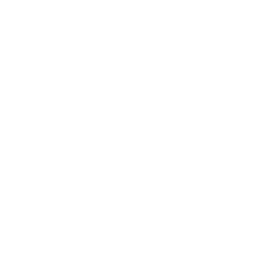

In [13]:
img1

In [4]:
def unet(pretrained_weights = None,input_size = (256,256,3)):
    inputs = Input(input_size)
    inputs_norm = Lambda(lambda x: x /255.0 - 0.5)(inputs)
    conv1 = Conv2D(16, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(inputs_norm)
    conv1 = Conv2D(16, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv1)
    pool1 = MaxPooling2D(pool_size=(2, 2))(conv1)
    conv2 = Conv2D(32, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(pool1)
    conv2 = Conv2D(32, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv2)
    pool2 = MaxPooling2D(pool_size=(2, 2))(conv2)
    conv3 = Conv2D(64, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(pool2)
    conv3 = Dropout(0.2)(conv3)
    conv3 = Conv2D(64, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv3)
    pool3 = MaxPooling2D(pool_size=(2, 2))(conv3)
    conv4 = Conv2D(128, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(pool3)
    conv4 = Conv2D(128, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv4)
    drop4 = Dropout(0.2)(conv4)
    pool4 = MaxPooling2D(pool_size=(2, 2))(drop4)

    conv5 = Conv2D(256, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(pool4)
    conv5 = Conv2D(256, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv5)
    drop5 = Dropout(0.2)(conv5)

    up6 = Conv2D(128, 2, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(UpSampling2D(size = (2,2))(drop5))
    merge6 = concatenate([drop4,up6], axis = 3)
    conv6 = Conv2D(128, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(merge6)
    conv6 = Conv2D(128, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv6)

    up7 = Conv2D(64, 2, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(UpSampling2D(size = (2,2))(conv6))
    merge7 = concatenate([conv3,up7], axis = 3)
    conv7 = Conv2D(64, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(merge7)
    conv7 = Conv2D(64, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv7)

    up8 = Conv2D(32, 2, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(UpSampling2D(size = (2,2))(conv7))
    merge8 = concatenate([conv2,up8], axis = 3)
    conv8 = Conv2D(32, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(merge8)
    conv8 = Conv2D(32, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv8)

    up9 = Conv2D(16, 2, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(UpSampling2D(size = (2,2))(conv8))
    merge9 = concatenate([conv1,up9], axis = 3)
    conv9 = Conv2D(16, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(merge9)
    conv9 = Conv2D(16, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv9)
    conv9 = Conv2D(2, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv9)
    conv10 = Conv2D(2, 1, activation = 'softmax')(conv9)

    model = Model(input = inputs, output = conv10)
    
    adam = optimizers.Adam(lr=0.0001, beta_1=0.9, beta_2=0.999, epsilon=None, decay=0.0, amsgrad=False)
    model.compile(loss='categorical_crossentropy', optimizer=adam, metrics=['accuracy'])
    #model.summary()

    if (pretrained_weights):
        model.load_weights(pretrained_weights)

    return model

In [5]:
def read_data_path():
    image_paths = []
    with open('train.txt','r') as f:
        for line in f:
            line = line.rstrip('\n')
            image_paths.append(line)
    #print('image_path # : ',len(image_paths))

    tumor_mask_paths = []

    with open('train_mask.txt','r') as f:
        for line in f:
            line = line.rstrip('\n')
            tumor_mask_paths.append(line)
    #print('mask_patch # : ',len(tumor_mask_paths))
    
    return image_paths, tumor_mask_paths

def read_test_data_path():
    image_paths = []
    with open('test.txt','r') as f:
        for line in f:
            line = line.rstrip('\n')
            image_paths.append(line)
    #print('image_path # : ',len(image_paths))
    
    return image_paths

test_image_paths = read_test_data_path()
image_paths, tumor_mask_paths = read_data_path()
image_paths = []
with open('train.txt','r') as f:
    for line in f:
        line = line.rstrip('\n')
        image_paths.append(line)
print('image_path # : ',len(image_paths))

tumor_mask_paths = []
with open('train_mask.txt','r') as f:
    for line in f:
        line = line.rstrip('\n')
        tumor_mask_paths.append(line)
print('mask_patch # : ',len(tumor_mask_paths))

slide_4_list_1 = [[102,104,29,44],[144,55,30,18],[125,56,35,40],[54,65,21,36],[139,82,1,49],[73,108,7,23],[107,117,24,52],[106,103,27,13]
               ,[105,151,15,2],[75,100,41,9],[156,113,32,37],[150,88,39,10],[84,122,5,50],[93,118,53,47],[87,78,45,34],[116,98,48,46],
                [72,131,22,42]]
slide_4_list_2 = [[109,58,14,28],[101,69,11,43],[94,74,3,20],[64,140,17,16],[92,154,8,26],[99,60,0,33],[86,146,25,19],[68,112,38,51],
                 [71,136,31,4],[59,91,12,6]]
slide_4_list_3 = [[143,132,124,85],[95,120,81,77],[97,96,110,83],[152,128,149,155],[153,111,57,138],[134,135,114,76],
                  [123,90,121,61],[147,148,119,142],[66,137,63,80],[70,79,115,133],[129,141,127,145]]
slide_4_test = [[55,55,0,0]]

all_image_path = []
all_mask_path = []
for j in range(4):
    image_path = image_paths[slide_4_test[0][j]][1:] # 이 부분은 data 읽을때 고치자 ( [1:] 빼야함)
    mask_path = tumor_mask_paths[slide_4_test[0][j]][1:] # 이 부분은 data 읽을때 고치자
    all_image_path.append(image_path)
    all_mask_path.append(mask_path)

image_path # :  157
mask_patch # :  157


In [6]:
import numpy as np
from scipy.ndimage.interpolation import map_coordinates
from scipy.ndimage.filters import gaussian_filter

# Elastic transform
def elastic_transformations(alpha, sigma, rng=np.random.RandomState(42), 
                            interpolation_order=1):
    """Returns a function to elastically transform multiple images."""
    # Good values for:
    #   alpha: 2000
    #   sigma: between 40 and 60
    def _elastic_transform_2D(images):
        """`images` is a numpy array of shape (K, M, N) of K images of size M*N."""
        # Take measurements
        image_shape = images[0].shape
        # Make random fields
        dx = rng.uniform(-1, 1, image_shape) * alpha
        dy = rng.uniform(-1, 1, image_shape) * alpha
        # Smooth dx and dy
        sdx = gaussian_filter(dx, sigma=sigma, mode='reflect')
        sdy = gaussian_filter(dy, sigma=sigma, mode='reflect')
        # Make meshgrid
        x, y = np.meshgrid(np.arange(image_shape[1]), np.arange(image_shape[0]))
        # Distort meshgrid indices
        distorted_indices = (y + sdy).reshape(-1, 1), \
                            (x + sdx).reshape(-1, 1)

        # Map cooordinates from image to distorted index set
        transformed_images = [map_coordinates(image, distorted_indices, mode='reflect',
                                              order=interpolation_order).reshape(image_shape)
                              for image in images]
        return transformed_images
    return _elastic_transform_2D

In [53]:
ipath = all_image_path[3]
tpath = all_mask_path[3]

all_tissue_samples = find_patches_from_slide(ipath,tpath)
print('Total patches in slide: %d' % len(all_tissue_samples)) 
all_tissue_samples.iloc[:10]
all_tissue_samples.is_tumor.value_counts() 
test_start_time = datetime.now()
sample_gen = gen_imgs(all_image_path,all_mask_path,all_tissue_samples, 100, shuffle=True)
%time example_X, example_y  = next(sample_gen)
test_end_time = datetime.now()
print("5000 gen time: %.1f minutes" % ((test_end_time - test_start_time).seconds / 60,))


d:\anaconda\envs\tf-gpu\lib\site-packages\ipykernel_launcher.py:86: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


Total patches in slide: 5578
Wall time: 2.56 s
5000 gen time: 0.0 minutes


In [54]:
example_X.shape

(100, 256, 256, 3)

In [13]:
import numpy as np
import matplotlib.pyplot as plt
from keras.preprocessing.image import *


In [14]:
example_X[2:3].shape

(1, 256, 256, 3)

# Tensorflow Data Augmentation test

In [10]:
import tensorflow as tf

In [11]:
i = 3

In [12]:
from PIL import ImageEnhance as ie

In [13]:
brightness_param = np.random.uniform(0.25,1)
contrast_param = np.random.uniform(0.75,1)
color_param = np.random.uniform(0.25,1)
a = ie.Contrast(test_img).enhance(contrast_param)
a = ie.Brightness(a).enhance(brightness_param)
a = ie.Color(test_img).enhance(color_param)

NameError: name 'test_img' is not defined

In [14]:
type(a)

NameError: name 'a' is not defined

In [15]:
np.array(a).shape

NameError: name 'a' is not defined

In [16]:
example_X[i].shape

(256, 256, 3)

In [17]:
type(example_X[i])

numpy.ndarray

In [18]:
example_X[i].shape

(256, 256, 3)

In [19]:
from matplotlib import cm

In [20]:
test_img = Image.fromarray(example_X[i].astype('uint8'))

In [21]:
test_img = tf.reshape(test_img,(256,256,3))

In [22]:
type(test_img)

tensorflow.python.framework.ops.Tensor

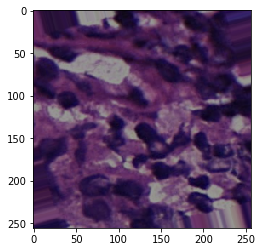

In [23]:
fig, ax = plt.subplots(ncols = 1)
ax.imshow(example_X[14]/255)

In [24]:
img = elastic_transform(example_X[i],example_X[i].shape[1]*2,example_X[i].shape[1]*0.08,example_X[i].shape[1]*0.08)
img = img.reshape(1,256,256,3)

In [105]:
i = 95

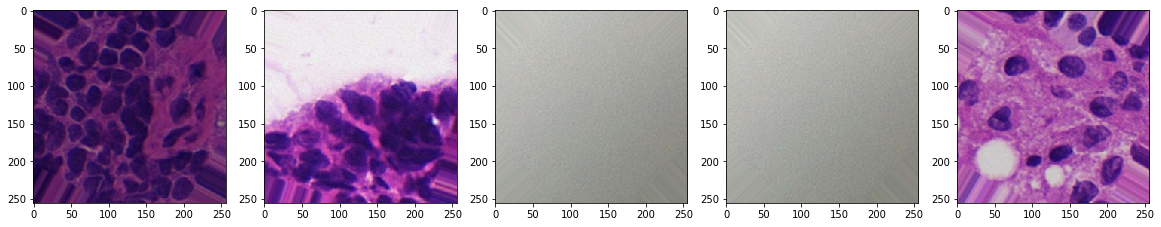

In [106]:
#img = example_X[2:3]
img_origin = example_X[2:3]
fig, ax = plt.subplots(1, 5, figsize=(20, 10))
ax = ax.ravel()
ax[0].imshow(example_X[i]/255)
ax[1].imshow(example_X[i+1]/255)
ax[2].imshow(example_X[i+2]/255)
ax[3].imshow(example_X[i+2]/255)
ax[4].imshow(example_X[i+3]/255)

In [62]:
from keras import optimizers

In [ ]:
model = unet(pretrained_weights='u_3.h5')

columns = ['is_tissue','slide_path','is_tumor','is_all_tumor','tile_loc']

BATCH_SIZE = 64
N_EPOCHS = 10

for i in range(len(slide_4_test)):
    
    # [1] dataset , 2 pos, 2 neg, mean ratio = 3:1
    four_samples = pd.DataFrame(columns = columns)
    four_image_path = list()
    four_mask_path = list()    
    for j in range(4):
        image_path = image_paths[slide_4_test[i][j]][1:] # 이 부분은 data 읽을때 고치자 ( [1:] 빼야함)
        mask_path = tumor_mask_paths[slide_4_test[i][j]][1:] # 이 부분은 data 읽을때 고치자
        samples = find_patches_from_slide(image_path, mask_path)
        
        four_samples = four_samples.append(samples)   
        four_image_path.append(image_path)
        four_mask_path.append(mask_path)
    NUM_SAMPLES = len(four_samples)
    if NUM_SAMPLES > 20000:
        NUM_SAMPLES = 20000
    
    samples = four_samples.sample(NUM_SAMPLES, random_state=42)
    samples.reset_index(drop=True, inplace=True)
    
    tumor_samples = four_samples[four_samples.is_tumor == True]
    print(len(tumor_samples))
    non_tumor_samples = four_samples[four_samples.is_tumor == False]
    print(len(non_tumor_samples))
    non_tumor_samples_3_ratio = non_tumor_samples.sample(len(tumor_samples) * 3, random_state = 42,replace=True)
    
    all_sample = tumor_samples.append(non_tumor_samples_3_ratio)

    split = StratifiedShuffleSplit(n_splits=1, test_size=0.2, random_state=42)
    for train_index, test_index in split.split(samples, samples["is_tumor"]):
            train_samples = samples.loc[train_index]
            validation_samples = samples.loc[test_index]
    
    train_generator = gen_imgs(four_image_path,four_mask_path,train_samples, BATCH_SIZE)
    validation_generator = gen_imgs(four_image_path,four_mask_path,validation_samples, BATCH_SIZE)
    
    train_start_time = datetime.now()
    history = model.fit_generator(train_generator, np.ceil(len(train_samples) / BATCH_SIZE),
        validation_data=validation_generator,
        validation_steps=np.ceil(len(validation_samples) / BATCH_SIZE),
        epochs=N_EPOCHS, verbose=2)
    
    #del train_generator
    #del validation_generator    train_end_time = datetime.now()
    print("Model training time: %.1f minutes" % ((train_end_time - train_start_time).seconds / 60,))
    model.save('u_3.h5')
    
    # split
    # data gen : all_image_path, all_mask_path

d:\anaconda\envs\tf-gpu\lib\site-packages\ipykernel_launcher.py:45: UserWarning: Update your `Model` call to the Keras 2 API: `Model(inputs=Tensor("in..., outputs=Tensor("co...)`
d:\anaconda\envs\tf-gpu\lib\site-packages\ipykernel_launcher.py:86: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


61446
160136
Epoch 1/10


In [10]:
model.save('u_3.h5')

# Test

In [74]:
def gen_imgs_test(slide_path, truth_path, samples, batch_size, patch_size = PATCH_SIZE,num_epoch = 1, shuffle=True):
    """This function returns a generator that 
    yields tuples of (
        X: tensor, float - [batch_size, patch_size, patch_size, 3]
        y: tensor, int32 - [batch_size, patch_size, patch_size, NUM_CLASSES]
    )
    
    
    input: samples: samples dataframe
    input: batch_size: The number of images to return for each pull
    output: yield (X_train, y_train): generator of X, y tensors
    
    option: base_truth_dir: path, directory of truth slides
    option: shuffle: bool, if True shuffle samples
    """
    
    num_samples = len(samples)
    slide_contains_tumor = 'pos' in slide_path    
    slide = openslide.open_slide(slide_path)
    #with openslide.open_slide(slide_path) as slide:
    tiles = DeepZoomGenerator(slide,tile_size=patch_size, overlap=0, limit_bounds=False) # 이거 limit_bounds =True하면 저거 굳이 안가져와도 될텐데
    
    # start_x = int(slide.properties.get('openslide.bounds-x',0))
    # start_y = int(slide.properties.get('openslide.bounds-y',0))
    # start_x = start_x / patch_size
    # start_y = start_y / patch_size
    start_x = 0
    start_y = 0

        #img = tiles.get_tile(tiles.l
        # level_count-1, (x,y))
    file_handles.append(slide)
    
    
    if slide_contains_tumor:
        truth = openslide.open_slide(truth_path)
        #with openslide.open_slide(truth_path) as truth:
        truth_tiles = DeepZoomGenerator(truth, tile_size=16, overlap=0, limit_bounds=False)
            
    
    
    for epo in range(1): # Loop forever so the generator never terminates
        if shuffle:
            samples = samples.sample(frac=1) # shuffle samples
        print('inferencing...')
        for offset in range(0, num_samples, batch_size):
            batch_samples = samples.iloc[offset:offset+batch_size]
            images = []
            masks = []
            aug_size = len(batch_samples)
            for _, batch_sample in batch_samples.iterrows(): # 배치마다 deep zoom 하네 약간 비효율적
                
                x, y = batch_sample.tile_loc[::-1]
                x += start_x
                y += start_y
                img = tiles.get_tile(tiles.level_count-1, (x,y))
                
                mask_size_up = np.zeros((patch_size,patch_size))
                a,b=mask_size_up.shape
                # only load truth mask for tumor slides
                if slide_contains_tumor:
                    mask = truth_tiles.get_tile(truth_tiles.level_count-1, batch_sample.tile_loc[::-1])
                    mask = (cv2.cvtColor(np.array(mask), cv2.COLOR_RGB2GRAY) > 0).astype(int)
                        # mask_size_up , 16 to 256
                    k, l = mask.shape
                    for i in range(k):
                        for j in range(l):
                            for o in range(16):
                                for p in range(16):
                                    mask_size_up[i*16+o,j*16+p] = mask[i][j]

                if img.size != (patch_size,patch_size):
                    print('this tisuue shape is not ',(patch_size,patch_size))
                    img = Image.new('RGB', (patch_size,patch_size))
                    mask_size_up = np.zeros((patch_size,patch_size))




                images.append(np.array(img))
                masks.append(mask_size_up)

            
            
            X_train = np.array(images)
            y_train = np.array(masks)
            #print('x_train_shape :', X_train.shape)
            
#             X_train, y_train = next(ImageDataGenerator(
#                 horizontal_flip=True,
#                 vertical_flip=True,
#                 brightness_range =(0.25,1.)).flow(X_train,y=y_train,batch_size=batch_size))
            # for iii in range(aug_size):
            #     test_img = Image.fromarray(X_train[iii].astype('uint8'))
            #     #brightness_param = np.random.uniform(0.25,1)
            #     contrast_param = np.random.uniform(0.75,1.0)
            #     color_param = np.random.uniform(0.25,1.0)
            #     a = ie.Contrast(test_img).enhance(contrast_param)
            #     #a = ie.Brightness(a).enhance(brightness_param)
            #     a = ie.Color(test_img).enhance(color_param)
            #     X_train[iii] = np.array(a)
            y_train = to_categorical(y_train, num_classes=2).reshape(y_train.shape[0], patch_size, patch_size, 2) 
            #print('y_train_shape : ',y_train.shape)
            yield X_train, y_train


In [82]:
ipath = all_image_path[0]
tpath = all_mask_path[0]

# all_tissue_samples = find_patches_from_slide(ipath,tpath)
# print('Total patches in slide: %d' % len(all_tissue_samples)) 
# all_tissue_samples.iloc[:10]
# all_tissue_samples.is_tumor.value_counts() 
# test_start_time = datetime.now()
# sample_gen = gen_imgs(all_image_path,all_mask_path,all_tissue_samples, 5000, shuffle=True)
# %time example_X, example_y  = next(sample_gen)
# test_end_time = datetime.now()
# print("5000 gen time: %.1f minutes" % ((test_end_time - test_start_time).seconds / 60,))

start_x = PATCH_SIZE//4
start_y = PATCH_SIZE//4
pred_size = PATCH_SIZE//2

test_start_time = datetime.now()
preds = []
labels = []
for i in range(5000):
    prediction = predict_from_model(example_X[i],model)
    pred_X = np.zeros((pred_size,pred_size))
    y = example_y[i].argmax
    for x in range(start_x,start_x+pred_size):
        for y in range(start_y, start_y+pred_size):
            pred_X[x-start_x][y-start_y] = prediction[x][y]
            
    pred_s = pd.Series(pred_X.flatten())
    pre_p = np.sort(pred_s)[10000]
    max_p = np.max(pre_p)
    
    y = np.max(example_y[i].argmax(axis=2))
    preds.append(max_p)
    labels.append(y)
test_end_time = datetime.now()
print("Model test time: %.1f minutes" % ((test_end_time - test_start_time).seconds / 60,))    
fpr, tpr, thresholds = metrics.roc_curve(labels,preds,pos_label=1)
print(metrics.auc(fpr,tpr))

Model test time: 1.8 minutes
0.9933737713799241


In [80]:
ipath = all_image_path[0]
tpath = all_mask_path[0]

# all_tissue_samples = find_patches_from_slide(ipath,tpath)
# print('Total patches in slide: %d' % len(all_tissue_samples)) 
# all_tissue_samples.iloc[:10]
# all_tissue_samples.is_tumor.value_counts() 
# test_start_time = datetime.now()
# sample_gen = gen_imgs(all_image_path,all_mask_path,all_tissue_samples, 5000, shuffle=True)
# %time example_X, example_y  = next(sample_gen)
# test_end_time = datetime.now()
# print("5000 gen time: %.1f minutes" % ((test_end_time - test_start_time).seconds / 60,))

start_x = PATCH_SIZE//4
start_y = PATCH_SIZE//4
pred_size = PATCH_SIZE//2

test_start_time = datetime.now()
preds = []
labels = []
for i in range(5000):
    prediction = predict_from_model(example_X[i],model)
    pred_X = np.zeros((pred_size,pred_size))
    y = example_y[i].argmax
    pred_s = pd.Series(prediction.flatten())
    max_p = np.max(pred_s)
    
    y = np.max(example_y[i].argmax(axis=2))
    preds.append(max_p)
    labels.append(y)
test_end_time = datetime.now()
print("Model test time: %.1f minutes" % ((test_end_time - test_start_time).seconds / 60,))    
fpr, tpr, thresholds = metrics.roc_curve(labels,preds,pos_label=1)
print(metrics.auc(fpr,tpr))

Model test time: 0.5 minutes
0.99288541908521


In [81]:
ipath = all_image_path[0]
tpath = all_mask_path[0]

# all_tissue_samples = find_patches_from_slide(ipath,tpath)
# print('Total patches in slide: %d' % len(all_tissue_samples)) 
# all_tissue_samples.iloc[:10]
# all_tissue_samples.is_tumor.value_counts() 
# test_start_time = datetime.now()
# sample_gen = gen_imgs(all_image_path,all_mask_path,all_tissue_samples, 5000, shuffle=True)
# %time example_X, example_y  = next(sample_gen)
# test_end_time = datetime.now()
# print("5000 gen time: %.1f minutes" % ((test_end_time - test_start_time).seconds / 60,))

start_x = 32
start_y = 32
pred_size = 192

test_start_time = datetime.now()
preds = []
labels = []
for i in range(5000):
    prediction = predict_from_model(example_X[i],model)
    pred_X = np.zeros((pred_size,pred_size))
    y = example_y[i].argmax
    for x in range(start_x,start_x+pred_size):
        for y in range(start_y, start_y+pred_size):
            pred_X[x-start_x][y-start_y] = prediction[x][y]
    
    pred_s = pd.Series(pred_X.flatten())
    
    max_p = np.max(pred_s)
    
    y = np.max(example_y[i].argmax(axis=2))
    preds.append(max_p)
    labels.append(y)
test_end_time = datetime.now()
print("Model test time: %.1f minutes" % ((test_end_time - test_start_time).seconds / 60,))    
fpr, tpr, thresholds = metrics.roc_curve(labels,preds,pos_label=1)
print(metrics.auc(fpr,tpr))

Model test time: 3.3 minutes
0.9938207182106649


In [26]:
pred_X.shape

(192, 192)

In [40]:
np.sort(pred_s)[15000]

0.9633510708808899

In [ ]:
max_pred_x = np.max(preds)
max_pred_x

# min_pred_x = np.min(preds)
# min_pred_x

In [23]:
test_start_time = datetime.now()
slide = openslide.open_slide(ipath)
tiles = DeepZoomGenerator(slide,tile_size=256,overlap=0, limit_bounds=False) 
test_end_time = datetime.now()
print("Model test time: %.1f minutes" % ((test_end_time - test_start_time).seconds))

Model test time: 0.0 minutes
